In [1]:
import numpy as np
import tensorflow as tf
import random
import pickle
import matplotlib.pyplot as plt
from pylab import rcParams
from d_u import load_CIFAR10
import structures
def save_object(object, filename):
    with open(filename, 'wb') as output:
        pickle.dump(object,output,pickle.HIGHEST_PROTOCOL)

def load_object(object, fielname):
    with open(fielname, 'rb') as input:
        object = pickle.load(input)

def entropy(feed):
    return np.sum(-feed*np.log(feed),axis=-1)

def tf_entropy(feed):
    return tf.reduce_sum(-feed*tf.log(feed),axis=-1)
    
def accuracy_entropy(output,labels,thresh):
    correct = 0.
    wrong = 0.
    reject = entropy(output)>thresh
    reject = reject.astype("float")
    correct = (np.argmax(output,axis=1)==labels)

    correct = correct.astype("float")
    acc = np.sum(correct * (1-reject))/np.sum(1-reject)
    rej = np.mean(reject)
    if rej<1:
        #print("acc:{} rej:{}",acc,rej)
        return (acc,rej)
         
        
def accuracy_probability(output,labels,thresh):
    correct = 0.
    wrong = 0.
    reject = np.max(output,axis=1)<thresh
    reject = reject.astype("float")
    correct = (np.argmax(output,axis=1)==labels)

    correct = correct.astype("float")
    acc = np.sum(correct * (1-reject))/np.sum(1-reject)
    rej = np.mean(reject)
    if rej<1:
        #print("acc:{} rej:{}",acc,rej)
        return (acc,rej)
    
config_gpu = tf.ConfigProto()
config_gpu.gpu_options.allow_growth = True



In [2]:
def get_CIFAR10_data(num_training=40000, num_validation=10000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = '../../../../../lfs/1/amiratag/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
#     X_train /= 255
#     X_val /= 255
#     X_test /= 255
    return X_train, y_train, X_val, y_val, X_test, y_test, mean_image

X_train, y_train, X_val, y_val, X_test, y_test, mean_image = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
X_train1 = X_train[:25000]
y_train1 = y_train[:25000]
X_val1 = X_val[:2000]
y_val1 = y_val[:2000]
X_train2 = X_train[25000:]
y_train2 = y_train[25000:]
X_val2 = X_val[5000:]
y_val2 = y_val[5000:]
X_train.shape
training_data = (X_train,y_train)
training_data1 = (X_train1, y_train1)
training_data2 = (X_train2, y_train2)
validation_data = (X_val,y_val)
validation_data1 = (X_val1,y_val1)
validation_data2 = (X_val2,y_val2)
test_data = (X_test, y_test)
train_mask = np.argsort(y_train)
val_mask = np.argsort(y_val2)
y_train_sorted = y_train[train_mask].copy()
y_val_sorted = y_val2[val_mask].copy()
X_train_sorted = X_train[train_mask].copy()
X_val_sorted = X_val2[val_mask].copy()
X_train_0 = X_train_sorted[:3900]
X_train_1 = X_train_sorted[4000:7900]
X_train_2 = X_train_sorted[8000:11900]
X_train_3 = X_train_sorted[12000:15900]
X_train_4 = X_train_sorted[16100:20000]
X_train_5 = X_train_sorted[20050:23950]
X_train_6 = X_train_sorted[24000:27900]
X_train_7 = X_train_sorted[28100:32000]
X_train_8 = X_train_sorted[32100:36000]
X_train_9 = X_train_sorted[36100:]
X_tr = [X_train_0,X_train_1,X_train_2,X_train_3,X_train_4,X_train_5,X_train_6,X_train_7,X_train_8,X_train_9]
X_val_0 = X_val_sorted[:400]
X_val_1 = X_val_sorted[500:900]
X_val_2 = X_val_sorted[1000:1400]
X_val_3 = X_val_sorted[1500:1900]
X_val_4 = X_val_sorted[2000:2400]
X_val_5 = X_val_sorted[2500:2900]
X_val_6 = X_val_sorted[3000:3400]
X_val_7 = X_val_sorted[3500:3900]
X_val_8 = X_val_sorted[4000:4400]
X_val_9 = X_val_sorted[4500:4900]
X_v = [X_val_0,X_val_1,X_val_2,X_val_3,X_val_4,X_val_5,X_val_6,X_val_7,X_val_8,X_val_9]

('Train data shape: ', (40000, 32, 32, 3))
('Train labels shape: ', (40000,))
('Validation data shape: ', (10000, 32, 32, 3))
('Validation labels shape: ', (10000,))
('Test data shape: ', (10000, 32, 32, 3))
('Test labels shape: ', (10000,))


In [3]:
def sphere_distortion(r,N,n,NET,w=32,h=32,c=3,hidden_size=1024,verbose=False,X_val=None):
    sess=get_session()
    saver = tf.train.Saver()
    saver.restore(sess,NET.path)  
    cond_nums=[]
    dists = np.zeros(n)
    points = np.zeros((n,w,h,c))
    points_mapped = np.zeros((n,hidden_size))
    for i in range(N):
        if verbose:
            if N>10:
                if i%(N//10)==0:
                    print(i)
            else:
                print(i)
        if X_val==None:
            point = 255*np.random.random((1,w,h,c))-mean_image
        else:
            point = np.expand_dims(X_val[np.random.choice(X_val.shape[0])],0)
        point_mapped = NET.scores(point,sess)
        if n<2000:
            points = point + r*unitpoint(n,32,32,3)
            points_mapped = NET.scores(points,sess)
            dists = np.linalg.norm(points_mapped-point_mapped,axis=1)
        else:
            for ctr in range(n//2000):
                points[ctr*2000:(ctr+1)*2000] = point + r*unitpoint(2000,w,h,c)
                points_mapped[ctr*2000:(ctr+1)*2000] = NET.scores(points[ctr*2000:(ctr+1)*2000],sess)
                dists[ctr*2000:(ctr+1)*2000] = sess.run(tf.norm(tf.constant(points_mapped[ctr*2000:(ctr+1)*2000])-
                                                                       tf.cast(tf.constant(point_mapped),tf.float64),1))

        cond_nums.append(max(dists)/min(dists))
    cond_nums = np.array(cond_nums)
    weights = 100*np.ones_like(cond_nums)/len(cond_nums)
    rcParams['figure.figsize'] = 10, 10
    plt.hist(cond_nums,20,weights=weights)
    plt.xlabel("k")
    plt.ylabel("%")
    print(np.mean(cond_nums),np.var(cond_nums))
    return cond_nums

def histogram_plotter(data,bins,xlabel=""):
    %matplotlib inline
    import matplotlib.pyplot as plt
    from pylab import rcParams
    weights = 100*np.ones_like(data)/len(data)
    plt.hist(data,bins,weights=weights)
    plt.xlabel(xlabel)
    plt.ylabel("%")

        
def PolMut(x, eta, prob,up,down):
    up = up*1.
    down = down*1.
    eta = eta*1.
    mask = (np.random.random(x.shape)<prob).astype("float")
    changed = mask*x
    unchanged = (1-mask)*x
    delta1 = x*mask/(up-down)
    delta2 = (1-x)*mask/(up-down)
    r = np.random.random(x.shape)
    r_mask = (r<0.5).astype("float")
    r_mask1 = r_mask * mask
    r_mask2 = (1-r_mask) * mask
    r1 = r * r_mask1
    r2 = r * r_mask2
    q1 = (2*r1+(1-2*r1)*r_mask1*(mask*(1-delta1))**(eta+1))
    q2 = (2*(1-r2)+2*(r2-0.5)*r_mask2*(mask*(1-delta2))**(eta+1))
    d = (q1**(1./(eta+1))-1) * r_mask1 + (1-q2**(1./(eta+1))) * r_mask2
    result = unchanged + changed+d*(up-down)
    return result


def get_session():
    """Create a session that dynamically allocates memory."""
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'
    
    
def cluster_points(X, mu):
    clusters  = {}
    for x in X:
        bestmukey = min([(i[0], np.linalg.norm(x-mu[i[0]])) \
                    for i in enumerate(mu)], key=lambda t:t[1])[0]
        try:
            clusters[bestmukey].append(x)
        except KeyError:
            clusters[bestmukey] = [x]
    return clusters
 
    
def reevaluate_centers(mu, clusters):
    newmu = []
    keys = sorted(clusters.keys())
    for k in keys:
        newmu.append(np.mean(clusters[k], axis = 0))
    return newmu
 
    
def has_converged(mu, oldmu):
    return (set([tuple(a) for a in mu]) == set([tuple(a) for a in oldmu]))
 
    
def find_centers(X, K):
    # Initialize to K random centers
    oldmu = random.sample(X, K)
    mu = random.sample(X, K)
    while not has_converged(mu, oldmu):
        oldmu = mu
        # Assign all points in X to clusters
        clusters = cluster_points(X, mu)
        # Reevaluate centers
        mu = reevaluate_centers(oldmu, clusters)
    return(mu, clusters)

def unitpoint(N,w,h,c):
    a = np.random.normal(size=(N,w*h*c))
    b = np.expand_dims(np.sqrt(np.sum(a**2,1)),1)
    return np.reshape(a/b,[N,w,h,c])
  
    
def random_triangle(N,w,h,c,r,mean_image,a=None):
    if a==None:
        a = 255*np.random.random((N,w,h,c))-mean_image
        a = np.reshape(a,[N,-1])
    base = np.reshape(r*unitpoint(N,w,h,c),[N,-1])
    base = base/np.expand_dims(np.linalg.norm(base,axis=1),-1)
    b = a + r*base
    orthog = np.reshape(unitpoint(N,w,h,c),[N,-1])
    orthog = orthog - np.expand_dims(np.diagonal(np.inner(orthog,base)),-1) * base
    orthog = orthog/np.expand_dims(np.linalg.norm(orthog,axis=1),-1)
    orthog = orthog * r * np.sqrt(3)/2
    c = a + r*base/2 + orthog
    return np.reshape(a,[N,w,h,-1]),np.reshape(b,[N,w,h,-1]),np.reshape(c,[N,w,h,-1])


def l2_distance(a,b):
    norm_a = np.sum(a**2,1,keepdims=True)
    norm_b = np.sum((b.T)**2,0,keepdims=True)
    output = -2*a.dot(b.T)
    output += norm_a
    output += norm_b
    return np.sqrt(output)

def tf_l2_distance(a,b):
    norm_a = tf.reduce_sum(a**2,axis=1,keep_dims=True)
    norm_b = tf.reduce_sum(tf.transpose(b)**2,axis=0,keep_dims=True)
    output = -2*tf.matmul(a,tf.transpose(b))
    output += norm_a
    output += norm_b
    return tf.sqrt(output)

def condition_number_dist(sess,r,NET,iters,num_points=32*32*3,w=32,h=32,c=3,mean_image=mean_image):
    for i in range(iters):
        if i%100==0:
            print(i)
        point = 255*np.random.random((1,w,h,c))-mean_image
        points = point + r*unitpoint(num_points,w,h,c)
        point_mapped = NET.scores(point,sess)
        points_mapped = NET.scores(points,sess)
        dists = np.linalg.norm(points_mapped-point_mapped,axis=1)
        cond_nums.append(max(dists)/min(dists))
    return cond_nums

In [4]:
def sphere_distortion(r,N,n,NET,w=32,h=32,c=3,hidden_size=1024,verbose=False,X_val=None):
    sess=get_session()
    saver = tf.train.Saver()
    saver.restore(sess,NET.path)  
    cond_nums=[]
    dists = np.zeros(n)
    points = np.zeros((n,w,h,c))
    points_mapped = np.zeros((n,hidden_size))
    for i in range(N):
        if verbose:
            if N>10:
                if i%(N//10)==0:
                    print(i)
            else:
                print(i)
        if X_val==None:
            point = 255*np.random.random((1,w,h,c))-mean_image
        else:
            point = np.expand_dims(X_val[np.random.choice(X_val.shape[0])],0)
        point_mapped = NET.scores(point,sess)
        if n<2000:
            points = point + r*unitpoint(n,32,32,3)
            points_mapped = NET.scores(points,sess)
            dists = np.linalg.norm(points_mapped-point_mapped,axis=1)
        else:
            for ctr in range(n//2000):
                points[ctr*2000:(ctr+1)*2000] = point + r*unitpoint(2000,w,h,c)
                points_mapped[ctr*2000:(ctr+1)*2000] = NET.scores(points[ctr*2000:(ctr+1)*2000],sess)
                dists[ctr*2000:(ctr+1)*2000] = sess.run(tf.norm(tf.constant(points_mapped[ctr*2000:(ctr+1)*2000])-
                                                                       tf.cast(tf.constant(point_mapped),tf.float64),1))

        cond_nums.append(max(dists)/min(dists))
    cond_nums = np.array(cond_nums)
    weights = 100*np.ones_like(cond_nums)/len(cond_nums)
    rcParams['figure.figsize'] = 10, 10
    plt.hist(cond_nums,20,weights=weights)
    plt.xlabel("k")
    plt.ylabel("%")
    print(np.mean(cond_nums),np.var(cond_nums))
    return cond_nums

def histogram_plotter(data,bins,xlabel=""):
    %matplotlib inline
    import matplotlib.pyplot as plt
    from pylab import rcParams
    weights = 100*np.ones_like(data)/len(data)
    plt.hist(data,bins,weights=weights)
    plt.xlabel(xlabel)
    plt.ylabel("%")

        
def PolMut(x, eta, prob,up,down):
    up = up*1.
    down = down*1.
    eta = eta*1.
    mask = (np.random.random(x.shape)<prob).astype("float")
    changed = mask*x
    unchanged = (1-mask)*x
    delta1 = x*mask/(up-down)
    delta2 = (1-x)*mask/(up-down)
    r = np.random.random(x.shape)
    r_mask = (r<0.5).astype("float")
    r_mask1 = r_mask * mask
    r_mask2 = (1-r_mask) * mask
    r1 = r * r_mask1
    r2 = r * r_mask2
    q1 = (2*r1+(1-2*r1)*r_mask1*(mask*(1-delta1))**(eta+1))
    q2 = (2*(1-r2)+2*(r2-0.5)*r_mask2*(mask*(1-delta2))**(eta+1))
    d = (q1**(1./(eta+1))-1) * r_mask1 + (1-q2**(1./(eta+1))) * r_mask2
    result = unchanged + changed+d*(up-down)
    return result


def get_session():
    """Create a session that dynamically allocates memory."""
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'
    
    
def cluster_points(X, mu):
    clusters  = {}
    for x in X:
        bestmukey = min([(i[0], np.linalg.norm(x-mu[i[0]])) \
                    for i in enumerate(mu)], key=lambda t:t[1])[0]
        try:
            clusters[bestmukey].append(x)
        except KeyError:
            clusters[bestmukey] = [x]
    return clusters
 
    
def reevaluate_centers(mu, clusters):
    newmu = []
    keys = sorted(clusters.keys())
    for k in keys:
        newmu.append(np.mean(clusters[k], axis = 0))
    return newmu
 
    
def has_converged(mu, oldmu):
    return (set([tuple(a) for a in mu]) == set([tuple(a) for a in oldmu]))
 
    
def find_centers(X, K):
    # Initialize to K random centers
    oldmu = random.sample(X, K)
    mu = random.sample(X, K)
    while not has_converged(mu, oldmu):
        oldmu = mu
        # Assign all points in X to clusters
        clusters = cluster_points(X, mu)
        # Reevaluate centers
        mu = reevaluate_centers(oldmu, clusters)
    return(mu, clusters)

def unitpoint(N,w,h,c):
    a = np.random.normal(size=(N,w*h*c))
    b = np.expand_dims(np.sqrt(np.sum(a**2,1)),1)
    return np.reshape(a/b,[N,w,h,c])
  
    
def random_triangle(N,w,h,c,r,mean_image,a=None):
    if a==None:
        a = 255*np.random.random((N,w,h,c))-mean_image
        a = np.reshape(a,[N,-1])
    base = np.reshape(r*unitpoint(N,w,h,c),[N,-1])
    base = base/np.expand_dims(np.linalg.norm(base,axis=1),-1)
    b = a + r*base
    orthog = np.reshape(unitpoint(N,w,h,c),[N,-1])
    orthog = orthog - np.expand_dims(np.diagonal(np.inner(orthog,base)),-1) * base
    orthog = orthog/np.expand_dims(np.linalg.norm(orthog,axis=1),-1)
    orthog = orthog * r * np.sqrt(3)/2
    c = a + r*base/2 + orthog
    return np.reshape(a,[N,w,h,-1]),np.reshape(b,[N,w,h,-1]),np.reshape(c,[N,w,h,-1])


def l2_distance(a,b):
    norm_a = np.sum(a**2,1,keepdims=True)
    norm_b = np.sum((b.T)**2,0,keepdims=True)
    output = -2*a.dot(b.T)
    output += norm_a
    output += norm_b
    return np.sqrt(output)

def tf_l2_distance(a,b):
    norm_a = tf.reduce_sum(a**2,axis=1,keep_dims=True)
    norm_b = tf.reduce_sum(tf.transpose(b)**2,axis=0,keep_dims=True)
    output = -2*tf.matmul(a,tf.transpose(b))
    output += norm_a
    output += norm_b
    return tf.sqrt(output)

def condition_number_dist(sess,r,NET,iters,num_points=32*32*3,w=32,h=32,c=3,mean_image=mean_image):
    for i in range(iters):
        if i%100==0:
            print(i)
        point = 255*np.random.random((1,w,h,c))-mean_image
        points = point + r*unitpoint(num_points,w,h,c)
        point_mapped = NET.scores(point,sess)
        points_mapped = NET.scores(points,sess)
        dists = np.linalg.norm(points_mapped-point_mapped,axis=1)
        cond_nums.append(max(dists)/min(dists))
    return cond_nums

In [5]:
class CNN_SC(object):
    
    def __init__(self,  centers, new_loss, network_name, num_conv_layers, num_forward_layers, input_shape, num_classes, path, 
                 kernel_sizes, hidden_sizes, pool_sizes, dims, learning_rate = 0.001, padding = "SAME", initialize=False,
                 dropout = 1, reject_cost = 0.2, activation="relu",  reg = 0, dynamic = False, batch_norm=True, double=False):
        self.double = double
        self.new_loss = new_loss
        self.network_name = network_name
        self.num_forward_layers = num_forward_layers
        self.num_conv_layers = num_conv_layers
        self.batch_norm = batch_norm
        self.input_shape = input_shape #FIXIT: assumption is images are square
        self.dims = dims
        self.padding = padding
        self.learning_rate = learning_rate
        self.pool_sizes = pool_sizes
        self.hidden_sizes = hidden_sizes
        self.kernel_sizes = kernel_sizes
        self.num_classed = num_classes
        self.dropout = dropout
        self.dynamic = dynamic
        self.num_classes = num_classes
        self.path = path
        self.cost_history = []
        self.reg = reg
        self.out_dict = {}
        self.flatten_size = self.flatten_size_calculator()
        self.Pdic = self.make_Pdic()
        self.initialize = initialize
        if double:
            self.centers1, self.centers2 = centers
        else:
            self.centers = centers
        self.input_ph = tf.placeholder(dtype= tf.float32, 
                                       shape= [None, self.input_shape[0],self.input_shape[1],self.input_shape[2]])
        self.output_ph = tf.placeholder(dtype= tf.int32, 
                                        shape= [None,])
        self.is_training_ph = tf.placeholder(tf.bool)
        self.activation = self.get_activation(activation)
        self.build(self.input_ph)
        
    def make_Pdic(self):
        
        Pdic = {}
        
        Pdic["W"] = tf.get_variable("W", shape = [self.hidden_sizes[self.num_forward_layers-1],self.num_classes],
                                    initializer=tf.contrib.layers.xavier_initializer())
        Pdic["b"] = tf.get_variable("b", shape=[self.num_classes], initializer=tf.zeros_initializer())
        
        self.sum_weights = tf.reduce_sum( Pdic["W"]**2)
        
        flat_length = self.flatten_size[self.num_conv_layers-1]
        
        for number in range(self.num_conv_layers):
            Pdic["K{}".format(number)] =  tf.get_variable("K{}".format(number), 
                                                               shape=[self.kernel_sizes[number],self.kernel_sizes[number],
                                                              (number==0)*self.input_shape[-1] + (number>0)*self.dims[number-1],
                                                              self.dims[number]],initializer=tf.contrib.layers.xavier_initializer())
            Pdic["z{}".format(number)] = tf.get_variable("z{}".format(number), shape = [self.dims[number]], 
                                                          initializer=tf.zeros_initializer())
        
        for layer in range(self.num_forward_layers):
            
            Pdic["W{}".format(layer)] = tf.get_variable("W{}".format(layer),
                                                             shape=[flat_length*(layer==0)+self.hidden_sizes[layer-1]*(layer>0),
                                                                    self.hidden_sizes[layer]],
                                 initializer=tf.contrib.layers.xavier_initializer())
            self.sum_weights += tf.reduce_sum( Pdic["W{}".format(layer)]**2)
            Pdic["b{}".format(layer)] = tf.get_variable("b{}".format(layer), 
                                                             shape=[self.hidden_sizes[layer]], initializer=tf.zeros_initializer())
        return Pdic
        

    
    def calculate_dic(self):
        dic = {}
        corrects = tf.cast(tf.equal(tf.cast(tf.argmax(self.out,1),tf.int32),self.output_ph),"float")
        dic["accuracy"] = tf.reduce_mean(corrects)  
        return dic

    def get_activation(self, name):
        if name == "relu":
            return tf.nn.relu
        if name == "tanh":
            return tf.nn.tanh
        if name == "sigmoid":
            return tf.sigmoid
    
    
    def conv_layer(self, number, feed):
        
        conv = tf.nn.conv2d(input=feed, filter=self.Pdic["K{}".format(number)], padding="SAME", strides=[1,1,1,1])
        out_convv = self.activation(conv + self.Pdic["z{}".format(number)])
        if self.batch_norm:
            out_conv = tf.layers.batch_normalization(out_convv,axis=-1,training=self.is_training_ph)
        else:
            out_conv = out_convv
        pool = tf.layers.max_pooling2d(inputs=out_conv, pool_size=self.pool_sizes[number], strides=self.pool_sizes[number])
        return pool
    
    def fc_layer(self, layer, feed):
        out = tf.matmul(feed,self.Pdic["W{}".format(layer)])+self.Pdic["b{}".format(layer)]
        out_relued = tf.nn.dropout(self.activation(out), self.dropout)
        return out_relued
    
    def flatten_size_calculator(self):
        output = np.zeros(self.num_conv_layers)
        temp = self.input_shape[0]//self.pool_sizes[0]
        output[0] = temp*temp*self.dims[0]
        for n in range(1,self.num_conv_layers):
            temp = temp//self.pool_sizes[n]
            output[n] = temp*temp*self.dims[n]
        return output.astype(int)
    
        
    def build(self, feed):
        double = self.double
        with tf.device('/gpu:1'):
            if double:
                centers1 = tf.cast(tf.constant(self.centers1),tf.float32)
                centers2 = tf.cast(tf.constant(self.centers2),tf.float32)
            else:
                if self.dynamic:
                    centers = tf.cast(tf.Variable(self.centers),tf.float32)

                else:
                    centers = tf.cast(tf.constant(self.centers),tf.float32)
            # FIXIT: assumption is all convolutions are square
            #_____________________Conv Layer0______________________________________________________________________________
            if not self.double:
                self.centers_var = centers
            out = feed
            for layer in range(self.num_conv_layers):
                out = self.conv_layer(layer, out)

            #_____________________Exit_____________________________________________________________________________________
            flat_length = self.flatten_size[self.num_conv_layers-1]
            out = tf.reshape(out, shape=[-1, flat_length])

            for layer in range(self.num_forward_layers):
                out = self.fc_layer(layer,out)

            self.hidden = out
            self.out = tf.matmul(self.hidden,self.Pdic["W"])+self.Pdic["b"]
            self.dic = self.calculate_dic()
            labels = tf.cast(tf.one_hot(self.output_ph,self.num_classes),tf.float32)
            if double:
                self.distances1 = tf_l2_distance(self.hidden,centers1)
                self.distances2 = tf_l2_distance(self.hidden,centers2)  
            else:
                self.distances = tf_l2_distance(self.hidden,centers)
            self.dic["cost"] = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=self.out, labels=self.output_ph))\
            + 0.5*self.reg*(self.sum_weights)
            if double:
                
                 self.dic["cost_h"] =  tf.reduce_mean(tf.reduce_sum(tf.minimum(self.distances1, self.distances2)* \
                                                                   (labels-self.new_loss*(1-labels)),axis=1))\
                +0.5*self.reg*(self.sum_weights)
            else:
                
                self.dic["cost_h"] =  tf.reduce_mean(tf.reduce_sum(self.distances * \
                                                                   (labels-self.new_loss*(1-labels)),axis=1))\
                +0.5*self.reg*(self.sum_weights)

            
            
            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            with tf.control_dependencies(update_ops):                                                                       
                self.dic["optmz_h"]= tf.train.AdamOptimizer(self.learning_rate).minimize(self.dic["cost_h"])
                self.dic["optmz"]= tf.train.AdamOptimizer(self.learning_rate).minimize(self.dic["cost"])
        if self.initialize:
            saver = tf.train.Saver()
            init = tf.global_variables_initializer() 
            sess = get_session()
            sess.run(init)
            saver.save(sess,self.path)
        

    
    def get_batches(self, training_data, batch_size, validation_data):   
        Xs = training_data[0]
        Ys = training_data[1]
        mask = np.random.permutation(len(Ys))
        Xs = Xs[mask]
        Ys = Ys[mask]
        X_batches = [Xs[k:k + batch_size] for k in range(0, len(Xs), batch_size)]
        Y_batches = [Ys[k:k + batch_size] for k in range(0, len(Ys), batch_size)]
        return X_batches, Y_batches, validation_data[0], validation_data[1]


    def do_epoch(self, sess, epoch, X_batches, Y_batches, X_val, Y_val, clustering, X_train, Y_train, verbose):
        avg_cost = 0
        mskn = np.random.choice(range(X_train.shape[0]),1000)
        x_train = X_train[mskn]
        y_train = Y_train[mskn]
        for X_batch, Y_batch in zip(X_batches, Y_batches):
            if clustering:
                _, c = sess.run([self.dic["optmz_h"], self.dic["cost_h"]], 
                                feed_dict={self.input_ph:X_batch, self.output_ph:Y_batch, self.is_training_ph:True})
                avg_cost += c/len(X_batch)
            else:
                _, c = sess.run([self.dic["optmz"], self.dic["cost"]], 
                                feed_dict={self.input_ph:X_batch, self.output_ph:Y_batch, self.is_training_ph:True})
                avg_cost += c/len(X_batch)
        self.cost_history.append(avg_cost)    
        if clustering:
            if not self.double:
                self.centers = sess.run(self.centers_var) #FIXIT
            val_h = sess.run(self.hidden,  feed_dict={self.input_ph:X_val, self.is_training_ph:False})
            acc, rate = self.evaluate(val_h,Y_val)
            tr_h = sess.run(self.hidden,  feed_dict={self.input_ph:x_train, self.is_training_ph:False})
            acc_train, _ = self.evaluate(tr_h,y_train)
            if verbose:
                print("epoch:{},validation accuracy:{},training accuracy:{},rate:{},cost:{}".format(epoch,acc,acc_train,rate,avg_cost))
        else:
            acc = sess.run(self.dic["accuracy"], 
                           feed_dict={self.input_ph:X_val, self.output_ph:Y_val, self.is_training_ph:False})
            acc_train = sess.run(self.dic["accuracy"],
                                 feed_dict={self.input_ph:x_train, self.output_ph:y_train, self.is_training_ph:False})
            if verbose:
                print("Epoch:{},acc:{},acc_train:{},cost:{}".format(epoch,acc,acc_train,avg_cost))
        
        return acc
    
    def tradeoff(self,sess, X_val, Y_val, clustering):
        self.acc_hist = []
        self.rate_hist = []
        self.thresh_list = []
        if clustering:
            val_h = sess.run(self.hidden,  feed_dict={self.input_ph:X_val, self.is_training_ph:False})
            r=0.
            thresh = 1e5*1.
            while(r<0.95):
                thresh /= 1.001
                self.thresh_list.append(thresh)
                a,r = self.evaluate(val_h,Y_val,thresh)
                r = 1-r
                self.acc_hist.append(a)
                self.rate_hist.append(r)
#                 print(thresh,a,r)
        else:
            val = sess.run(tf.nn.softmax(self.out),  feed_dict={self.input_ph:X_val, self.is_training_ph:False})
            ent = entropy(val)
            r = 0.
            thresh = 10.
            while(r<.95):
                thresh /= 1.01
                self.thresh_list.append(thresh)
                passes = (ent<thresh).astype(float)
                corrects = (np.argmax(val,1)==Y_val).astype(float) * passes
                a = np.sum(corrects)/np.sum(passes)
                r = 1-np.sum(passes)/val.shape[0]
                self.acc_hist.append(a)
                self.rate_hist.append(r)
#                 print(thresh,a,r)
        
    def optimize(self, clustering, training_data, validation_data, save, load , reg= 0, epochs=10,
                 batch_size= 200, tradeoff=False, verbose=True, save_always=False):
        X_batches, Y_batches, X_val, Y_val = self.get_batches(training_data, batch_size, validation_data)
        X_train = training_data[0]
        Y_train = training_data[1]
        saver = tf.train.Saver()
        init = tf.global_variables_initializer() 

        with tf.Session(config=config_gpu) as sess:
            sess.run(init)
            best_val = 0.
            
            if load:
                if verbose:
                    print("Loading model from :{}".format(self.path))
                saver.restore(sess,self.path)

            if clustering:
                val_h = sess.run(self.hidden,  feed_dict={self.input_ph:X_val, self.is_training_ph:False})
                best_val, _ = self.evaluate(val_h,Y_val)
                if verbose:
                    print("validation accuracy before starting",best_val)
            else:
                best_val = sess.run(self.dic["accuracy"], 
                                    feed_dict={self.input_ph:X_val, self.output_ph:Y_val, self.is_training_ph:False})
                if verbose:
                    print("validation accuracy before starting",best_val)
                
            for epoch in range(epochs):
                acc = self.do_epoch(sess, epoch, X_batches, Y_batches, X_val, Y_val, clustering, X_train, Y_train, verbose)
                if acc>=best_val or save_always: #FIXIT
                    best_val = acc
                    saved_path = saver.save(sess, self.path)
                    if verbose:
                        print("New best!")
            self.best_val = best_val 
            print("Best val accuracy:",self.best_val)
            saver.restore(sess,self.path)
            if tradeoff:
                self.tradeoff(sess, X_val, Y_val, clustering)

    def tf_PolMut(self, x, eta=15., prob=0.1,up=255.0,down=0.):
        up = up*1.
        down = down*1.
        eta = eta*1.
        mask = tf.cast(tf.less(tf.random_uniform(tf.shape(x),0,1),prob),tf.float32)
        changed = mask*x
        unchanged = (1-mask)*x
        delta1 = x*mask/(up-down)
        delta2 = (1-x)*mask/(up-down)
        r = tf.cast(tf.random_uniform(tf.shape(x),0,1),tf.float32)
        r_mask = tf.cast(tf.less(r,0.5),tf.float32)
        r_mask1 = r_mask * mask
        r_mask2 = (1-r_mask) * mask
        r1 = r * r_mask1
        r2 = r * r_mask2
        q1 = (2*r1+(1-2*r1)*r_mask1*(mask*(1-delta1))**(eta+1))
        q2 = (2*(1-r2)+2*(r2-0.5)*r_mask2*(mask*(1-delta2))**(eta+1))
        d = (q1**(1./(eta+1))-1) * r_mask1 + (1-q2**(1./(eta+1))) * r_mask2
        result = unchanged + changed+d*(up-down)
        return result
    
    def PM(self, clustering, num_pic, num_iter, num_sample):
        saver = tf.train.Saver()
        with tf.Session(config=config_gpu) as sess:
            saver.restore(sess,self.path)
            best_pic = np.zeros((10*num_pic,32,32,3))
            best_score = 1e100*np.ones(10*num_pic)*1.
            
            for ctr in range(num_pic):
                x = 255*np.random.random((num_sample,32,32,3))    
                print(ctr)
                for i in range(num_iter):
                    if clustering:
                        hidden = sess.run(self.hidden, {self.input_ph: x-mean_image, self.is_training_ph: False})
                        out = l2_distance(hidden,self.centers)
                        min_index = out.argmin(axis=0)
                        for cls in range(10):
                            if out[min_index[cls]][cls]<best_score[cls*num_pic+ctr]:
                                best_score[cls*num_pic+ctr] = out[min_index[cls]][cls]
                                best_pic[cls*num_pic+ctr] = x[min_index[cls]]-mean_image
                    else:
                        out = sess.run(tf.nn.softmax(self.out), {self.input_ph: x-mean_image, self.is_training_ph: False})
                        max_index = out.argmax(axis=0)
                        for cls in range(10):
                            if out[max_index[cls]][cls]>best_score[cls*num_pic+ctr]:
                                best_score[cls*num_pic+ctr] = out[max_index[cls]][cls]
                                best_pic[cls*num_pic+ctr] = x[max_index[cls]]-mean_image
                    x = sess.run(self.tf_PolMut(tf.constant(x,dtype=tf.float32),15,.1,255.,0.))
        return best_pic, best_score
    
    def hist_dist(self,x,y):
        saver = tf.train.Saver()
        with tf.Session(config=config_gpu) as sess:
            saver.restore(sess,self.path)
            if self.double:
                distances1 = sess.run(self.distances1, {self.input_ph: x, self.output_ph:y, self.is_training_ph : False})
                distances2 = sess.run(self.distances2, {self.input_ph: x, self.output_ph:y, self.is_training_ph : False})
                distances = np.minimum(distances1,distances2)
            else:
                distances = sess.run(self.distances, {self.input_ph: x, self.output_ph:y, self.is_training_ph : False})
            output1 = distances[np.arange(y.shape[0]),y]
            return output1,distances
        
    def predict(self, hidden):
        index = -1
        counter = 0.
        correct = 0.
        out = np.zeros(hidden.shape[0])
        if self.double:
            diff = np.min()
        else:
            diff = l2_distance(hidden,self.centers)
        out = np.argmin(diff,axis=1)
        return out
    
    def evaluate(self, hidden, y, thresh=1e100):
        correct = 0.
        if self.double:
            diff1 = l2_distance(hidden,self.centers1)
            diff2 = l2_distance(hidden,self.centers2)
            diff = np.minimum(diff1,diff2)
        else:
            diff = l2_distance(hidden,self.centers)
            
        passed = np.min(diff,1)<thresh
        passed_num = np.sum(passed)
        correct = np.argmin(diff,1) == y     
        return np.sum(correct*passed)*1./passed_num, passed_num*1./y.shape[0]
            
    
    def feedforward(self, feed, sess=None):
        if sess==None:
            sess=get_session()
            saver = tf.train.Saver()
            saver.restore(sess,self.path)            
        output = sess.run(tf.nn.softmax(self.out), {self.input_ph: feed, self.is_training_ph : False})
        return output
    
    def scores(self, feed, sess=None):
        if sess==None:
            sess=get_session()
            saver = tf.train.Saver()
            saver.restore(sess,self.path)  
        output = sess.run(self.hidden, {self.input_ph: feed, self.is_training_ph : False})
        return output

In [6]:
clustering = False
best_val = 0.
learning_rate = [1e-3]
regularization = [0]
dropout = [1]
best_val=0
tf.reset_default_graph()
network3 = CNN_SC(centers = np.random.random((10,1024)),new_loss=0, network_name="network1", num_conv_layers=3, 
                   num_forward_layers=1,
                  input_shape=[32,32,3], reg = 1e-2,num_classes=10, kernel_sizes=[5,5,5], hidden_sizes=[1024], 
                  pool_sizes=[2,2,2], padding = "same", path ='../../../../../lfs/1/amiratag/saved_models/1C_3L_F',
                  dims=[64,128,256], learning_rate = 1e-3, batch_norm = True, dropout = 1)
network3.optimize(clustering, training_data, validation_data1, epochs=1, load = True, save = True, verbose=True)

a = tf.constant(X_val[3000:5000])
sess = tf.Session(config=config_gpu)
val_reshaped = tf.reshape(a,[-1,32*32*3])
dist_train = np.zeros((2000,40000))
for i in range(40):
    dist_train[:,i*1000:(i+1)*1000] = \
    sess.run(tf_l2_distance(val_reshaped,tf.reshape(tf.constant(X_train[i*1000:(i+1)*1000])
                                                    ,[-1,32*32*3])))
saver = tf.train.Saver()
saver.restore(sess,network3.path) 
train_mapped = np.zeros((40000,1024))
val_mapped = np.zeros((2000,1024))
dist_score_space = np.zeros((2000,40000))
for i in range(40):
    train_mapped[i*1000:(i+1)*1000] = network3.scores(X_train[i*1000:(i+1)*1000],sess)
val_mapped = network3.scores(X_val[3000:5000],sess)
for i in range(40):
    dist_score_space[:,i*1000:(i+1)*1000] =\
    sess.run(tf_l2_distance(tf.constant(val_mapped),
                            tf.cast(tf.constant(train_mapped[i*1000:(i+1)*1000]),tf.float32)))

args_train = np.argsort(dist_train,1) 
sorted_train = np.sort(dist_train,1)
args_score =np.argsort(dist_score_space,1) 
sorted_score = np.sort(dist_score_space,1)



Loading model from :../../../../../lfs/1/amiratag/saved_models/1C_3L_F
('validation accuracy before starting', 0.79300004)
Epoch:0,acc:0.790000081062,acc_train:1.00000011921,cost:0.0477985585108
('Best val accuracy:', 0.79300004)


In [23]:
memory_train=np.zeros((2000,2000))
memory_score=np.zeros((2000,2000))
for n in range(1,2001):
    for i in range(2000):
        memory_train[n-1,i] = np.sum(y_train[args_train[i,:n]]==y_val[3000+i])*1./n
        memory_score[n-1,i] = np.sum(y_train[args_score[i,:n]]==y_val[3000+i])*1./n

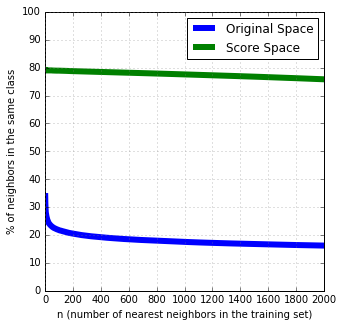

In [26]:
%matplotlib inline
rcParams['figure.figsize'] = 5, 5
rcParams.update({'font.size': 10})
plt.plot(range(1,2001),100*np.mean(memory_train,1),range(1,2001),
         100*np.mean(memory_score,1),linewidth=6)
plt.legend(["Original Space","Score Space"])
plt.xlabel("n (number of nearest neighbors in the training set)")
plt.ylabel("% of neighbors in the same class")
plt.xticks([0,200,400,600,800,1000,1200,1400,1600,1800,2000])
plt.yticks([0,10,20,30,40,50,60,70,80,90,100])
plt.axis([0,2000,0,100])
plt.grid(color="gray")

In [33]:
gooz=np.zeros(2000)
n=10000
for i in range(2000):
    gooz[i]=np.sum(y_train[args_train[i,:n]]==y_val[3000+i])*1./n
np.mean(gooz)

0.12917414999999999

In [13]:
i

233